In [2]:
%matplotlib inline

import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.cross_validation import StratifiedKFold, cross_val_score
from sklearn.metrics import roc_auc_score
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.grid_search import GridSearchCV
import xgboost as xgb
from scipy.stats import pearsonr

import imp
import llama

llama = imp.reload(llama)

In [3]:
train_df, test_X = llama.load_df("./data/train.csv", "./data/test.csv")

Train DataFrame:
Index(['ID', 'var3', 'var15', 'imp_ent_var16_ult1', 'imp_op_var39_comer_ult1',
       'imp_op_var39_comer_ult3', 'imp_op_var40_comer_ult1',
       'imp_op_var40_comer_ult3', 'imp_op_var40_efect_ult1',
       'imp_op_var40_efect_ult3',
       ...
       'saldo_medio_var33_hace2', 'saldo_medio_var33_hace3',
       'saldo_medio_var33_ult1', 'saldo_medio_var33_ult3',
       'saldo_medio_var44_hace2', 'saldo_medio_var44_hace3',
       'saldo_medio_var44_ult1', 'saldo_medio_var44_ult3', 'var38', 'TARGET'],
      dtype='object', length=371)
(76020, 371)
---
Test DataFrame:
Index(['ID', 'var3', 'var15', 'imp_ent_var16_ult1', 'imp_op_var39_comer_ult1',
       'imp_op_var39_comer_ult3', 'imp_op_var40_comer_ult1',
       'imp_op_var40_comer_ult3', 'imp_op_var40_efect_ult1',
       'imp_op_var40_efect_ult3',
       ...
       'saldo_medio_var29_ult3', 'saldo_medio_var33_hace2',
       'saldo_medio_var33_hace3', 'saldo_medio_var33_ult1',
       'saldo_medio_var33_ult3', 'saldo_medi

In [4]:
train_df.describe()

,ID,var3,var15,imp_ent_var16_ult1,imp_op_var39_comer_ult1,imp_op_var39_comer_ult3,imp_op_var40_comer_ult1,imp_op_var40_comer_ult3,imp_op_var40_efect_ult1,imp_op_var40_efect_ult3,...,saldo_medio_var33_hace2,saldo_medio_var33_hace3,saldo_medio_var33_ult1,saldo_medio_var33_ult3,saldo_medio_var44_hace2,saldo_medio_var44_hace3,saldo_medio_var44_ult1,saldo_medio_var44_ult3,var38,TARGET
count,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,...,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000
mean,75964.050723,-1523.199277,33.212865,86.208265,72.363067,119.529632,3.559130,6.472698,0.412946,0.567352,...,7.935824,1.365146,12.215580,8.784074,31.505324,1.858575,76.026165,56.614351,117235.809430,0.039569
std,43781.947379,39033.462364,12.956486,1614.757313,339.315831,546.266294,93.155749,153.737066,30.604864,36.513513,...,455.887218,113.959637,783.207399,538.439211,2013.125393,147.786584,4040.337842,2852.579397,182664.598503,0.194945
min,1.000000,-999999.000000,5.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5163.750000,0.000000
25%,38104.750000,2.000000,23.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,67870.612500,0.000000
50%,76043.000000,2.000000,28.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,106409.160000,0.000000
75%,113748.750000,2.000000,40.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,118756.252500,0.000000
max,151838.000000,238.000000,105.000000,210000.000000,12888.030000,21024.810000,8237.820000,11073.570000,6600.000000,6600.000000,...,50003.880000,20385.720000,138831.630000,91778.730000,438329.220000,24650.010000,681462.900000,397884.300000,22034738.760000,1.000000


In [5]:
def replace_very_low_var3(df):
    pass

train_df.loc[train_df["delta_imp_aport_var17_1y3"] == 9999999999, :].head()

col_sizes = {}
for col in train_df.columns:
    if col != "TARGET" and col != "ID":
        col_sizes[col] = len(set(train_df[col])), len(set(test_X[col]))

from collections import Counter
Counter(dict(sorted(col_sizes.items(), key = lambda x: x[1], reverse = False)).values())
set(train_df["delta_num_aport_var13_1y3"]), set(test_X["delta_num_aport_var13_1y3"])

({-1.0, -0.5, -0.33333333300000001, 0.0, 1.0, 9999999999.0},
 {-1.0, -0.5, 0.0, 1.0, 2.0, 3.0, 9999999999.0})

In [6]:
for key, val in col_sizes.items():
    if val == (2,2):
        print(key, set(train_df[key]), set(test_X[key]))

ind_var40 {0, 1} {0, 1}
ind_var13 {0, 1} {0, 1}
ind_var30_0 {0, 1} {0, 1}
num_var39 {0, 3} {0, 3}
ind_var1_0 {0, 1} {0, 1}
ind_var13_medio {0, 1} {0, 1}
imp_trasp_var33_out_ult1 {0, 3000} {0.0, 5625.3299999999999}
ind_var1 {0, 1} {0, 1}
ind_var24 {0, 1} {0, 1}
ind_var7_emit_ult1 {0, 1} {0, 1}
ind_var34 {0, 1} {0, 1}
num_var6 {0, 3} {0, 3}
ind_var26_cte {0, 1} {0, 1}
ind_var24_0 {0, 1} {0, 1}
ind_var30 {0, 1} {0, 1}
delta_imp_amort_var34_1y3 {0, 9999999999} {0, 9999999999}
ind_var43_recib_ult1 {0, 1} {0, 1}
ind_var12_0 {0, 1} {0, 1}
num_var20_0 {0, 3} {0, 3}
ind_var9_cte_ult1 {0, 1} {0, 1}
delta_imp_reemb_var13_1y3 {0, 9999999999} {0, 9999999999}
ind_var31_0 {0, 1} {0, 1}
ind_var32_0 {0, 1} {0, 1}
ind_var12 {0, 1} {0, 1}
ind_var37 {0, 1} {0, 1}
ind_var14 {0, 1} {0, 1}
ind_var29_0 {0, 1} {0, 1}
ind_var14_0 {0, 1} {0, 1}
ind_var26 {0, 1} {0, 1}
ind_var13_0 {0, 1} {0, 1}
ind_var20 {0, 1} {0, 1}
ind_var25_0 {0, 1} {0, 1}
ind_var34_0 {0, 1} {0, 1}
ind_var19 {0, 1} {0, 1}
num_var29_0 {0, 3} {

In [7]:
print(train_df.shape)
print(test_X.shape)

for key, val in col_sizes.items():
    if val == (1, 1):
        print(key)
        train_df.drop(key, 1, inplace=True)
        test_X.drop(key, 1, inplace=True)
        
print(train_df.shape)
print(test_X.shape)

(76020, 371)
(75818, 370)
saldo_var27
ind_var46_0
imp_reemb_var13_hace3
num_var46
imp_trasp_var33_out_hace3
saldo_var2_ult1
num_var46_0
ind_var28_0
ind_var28
num_var27
num_var28_0
num_trasp_var17_out_hace3
num_trasp_var33_out_hace3
num_var28
imp_trasp_var17_out_hace3
ind_var2_0
num_var2_0_ult1
imp_reemb_var33_hace3
saldo_medio_var13_medio_hace3
ind_var41
ind_var46
num_reemb_var13_hace3
ind_var2
ind_var27
ind_var27_0
num_var27_0
imp_amort_var18_hace3
num_reemb_var33_hace3
saldo_var46
imp_amort_var34_hace3
num_var41
saldo_var41
num_var2_ult1
saldo_var28
(76020, 337)
(75818, 336)


In [8]:
print(train_df.shape)
print(test_X.shape)

for key, val in col_sizes.items():
    if val == (2, 1) or val == (2, 2):
        print(key)
        train_df.loc[train_df[key] > 0, key] = 1
        test_X.loc[test_X[key] > 0, key] = 1
        
print(train_df.shape)
print(test_X.shape)

(76020, 337)
(75818, 336)
ind_var40
ind_var13
ind_var30_0
num_var39
ind_var1_0
ind_var13_medio
imp_trasp_var33_out_ult1
ind_var1
ind_var24
ind_var7_emit_ult1
ind_var34
num_var6
ind_var26_cte
ind_var24_0
ind_var30
delta_num_trasp_var17_out_1y3
delta_imp_amort_var34_1y3
ind_var43_recib_ult1
ind_var12_0
num_var20_0
ind_var9_cte_ult1
delta_imp_reemb_var13_1y3
ind_var31_0
ind_var32_0
ind_var12
ind_var37
num_reemb_var33_ult1
ind_var14
ind_var29_0
ind_var14_0
ind_var26
num_reemb_var17_hace3
ind_var13_0
ind_var20
ind_var25_0
ind_var34_0
ind_var19
num_var29_0
delta_num_reemb_var13_1y3
ind_var7_recib_ult1
imp_reemb_var17_hace3
ind_var18
ind_var17_0
num_var20
delta_imp_reemb_var33_1y3
num_var34
ind_var25
num_meses_var13_medio_ult3
ind_var32
num_var29
ind_var13_corto
ind_var37_cte
ind_var32_cte
ind_var13_corto_0
ind_var10cte_ult1
delta_num_trasp_var33_out_1y3
ind_var44_0
num_var34_0
num_var18
ind_var25_cte
ind_var44
ind_var39_0
num_var18_0
ind_var37_0
ind_var33
num_trasp_var17_out_ult1
imp_reemb_v

In [9]:
col_cors = {}
for col1 in train_df.columns:
    for col2 in train_df.columns:
        if col1 != "ID" and col2 != "TARGET" and (col1 + " : " + col2) not in col_cors and (col2 + " : " + col1) not in col_cors:
            col_cors[col1 + " : " + col2] = pearsonr(train_df[col1], train_df[col2])

/home/vadim/anaconda3/lib/python3.5/site-packages/statsmodels/nonparametric/kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


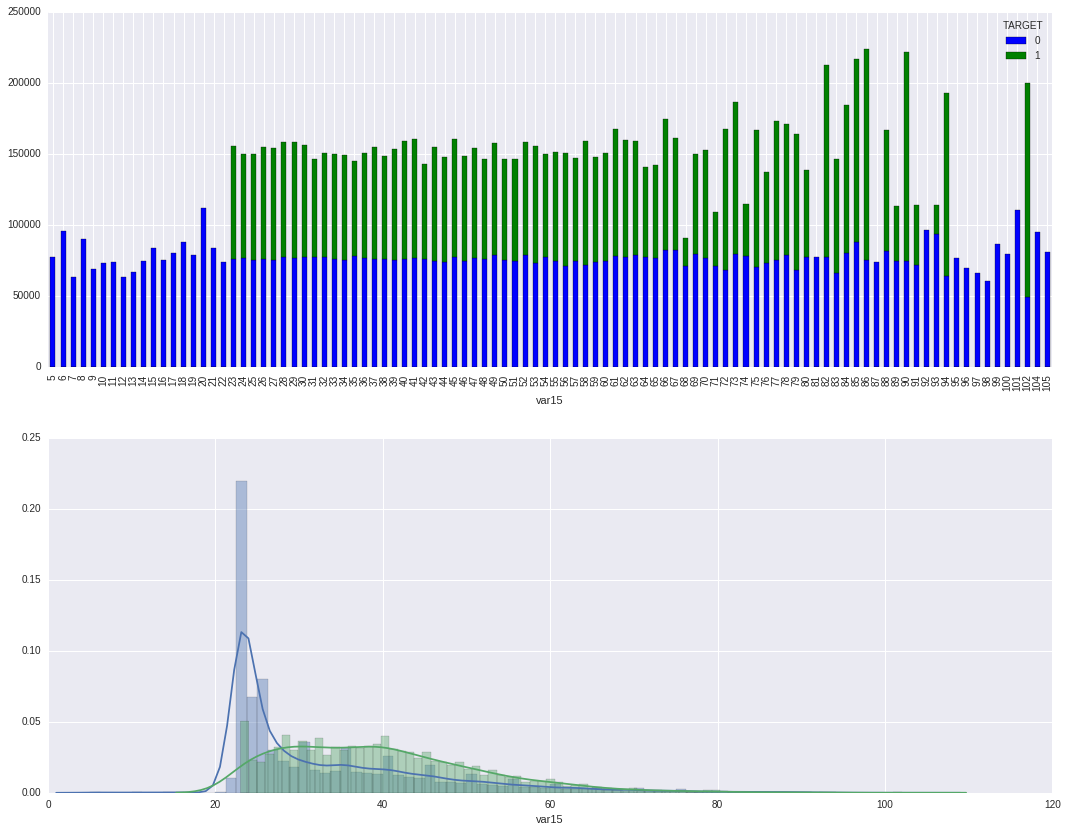

In [10]:
fig, axes = plt.subplots(ncols = 1, nrows = 2)
fig.set_size_inches(18, 14)
col = "var15"
train_df.pivot_table("ID", col, "TARGET").plot(ax = axes[0], kind = "bar", stacked = True)
sns.distplot(train_df.loc[train_df["TARGET"] == 0, col], bins = 80, ax = axes[1])
sns.distplot(train_df.loc[train_df["TARGET"] == 1, col], bins = 80, ax = axes[1])

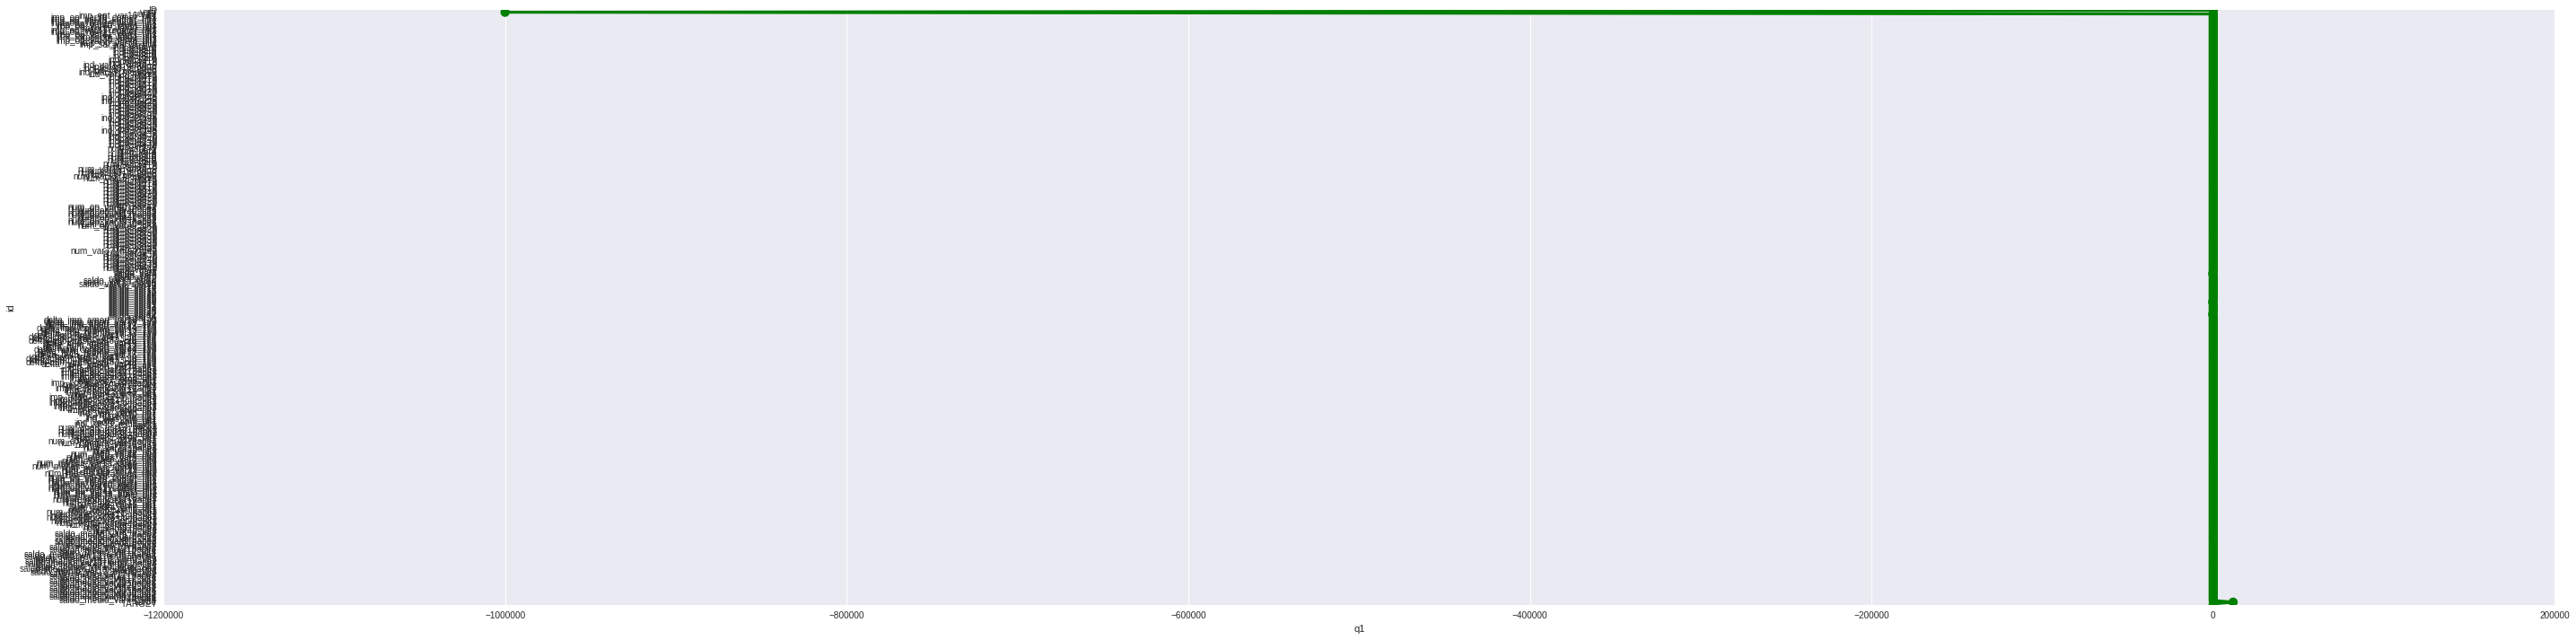

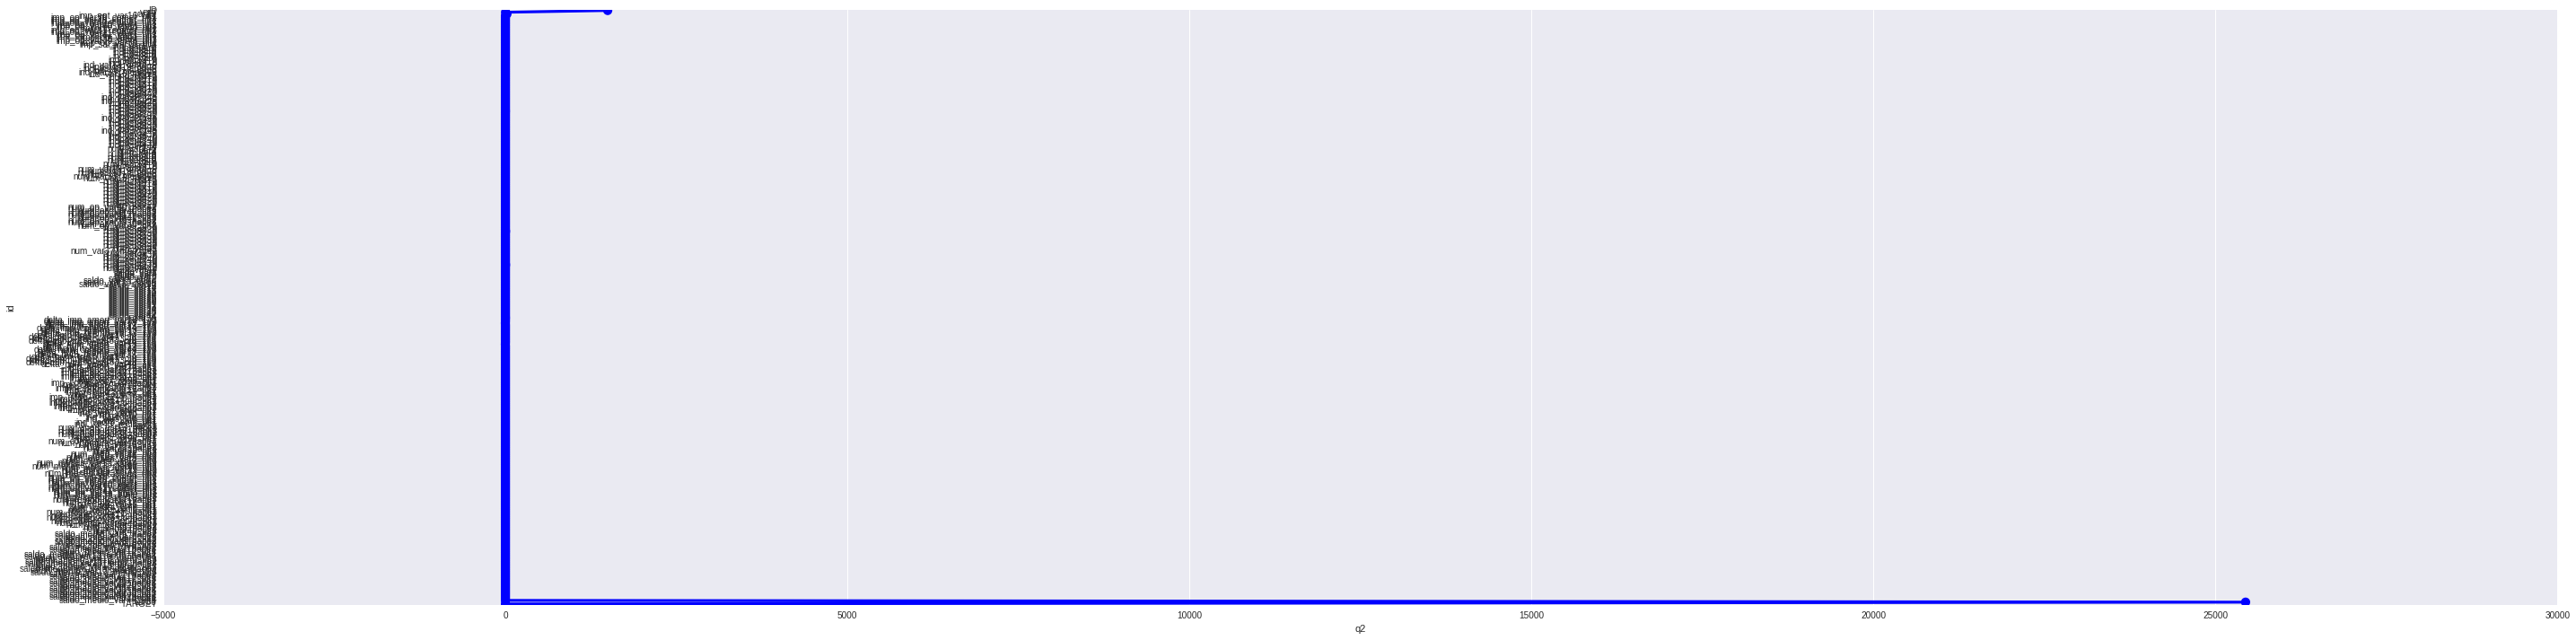

In [11]:
q1 = train_df.apply(np.percentile, axis=0, q = .025)
q2 = train_df.apply(np.percentile, axis=0, q = .975)
q_df = pd.DataFrame({"q1": q1, "q2": q2})
q_df["id"] = q_df.index
sns.factorplot(y="id", x="q1", data=q_df, size = 10, aspect = 4, color = "green")
sns.factorplot(y="id", x="q2", data=q_df, size = 10, aspect = 4, color = "blue")

In [12]:
print("Q.025")
print(abs(q1).sort_values().tail(25))
print("\nQ.975")
print(abs(q2).sort_values().tail(25))

Q.025
num_op_var40_hace3                 0.000000
num_op_var41_hace2                 0.000000
num_op_var39_hace2                 0.000000
num_op_var39_ult1                  0.000000
num_op_var40_hace2                 0.000000
num_var25                          0.000000
num_var25_0                        0.000000
num_var26                          0.000000
num_op_var39_hace3                 0.000000
num_op_var41_hace3                 0.000000
delta_num_compra_var44_1y3         0.331750
delta_imp_aport_var33_1y3          0.914974
delta_imp_compra_var44_1y3         0.968460
delta_num_aport_var13_1y3          1.000000
delta_imp_aport_var13_1y3          1.000000
saldo_medio_var5_hace2             2.278147
var15                              5.000000
saldo_medio_var5_ult3              5.187720
saldo_medio_var5_ult1             36.149430
ID                                43.009500
saldo_var5                       282.925447
saldo_var30                      306.538792
saldo_var42               

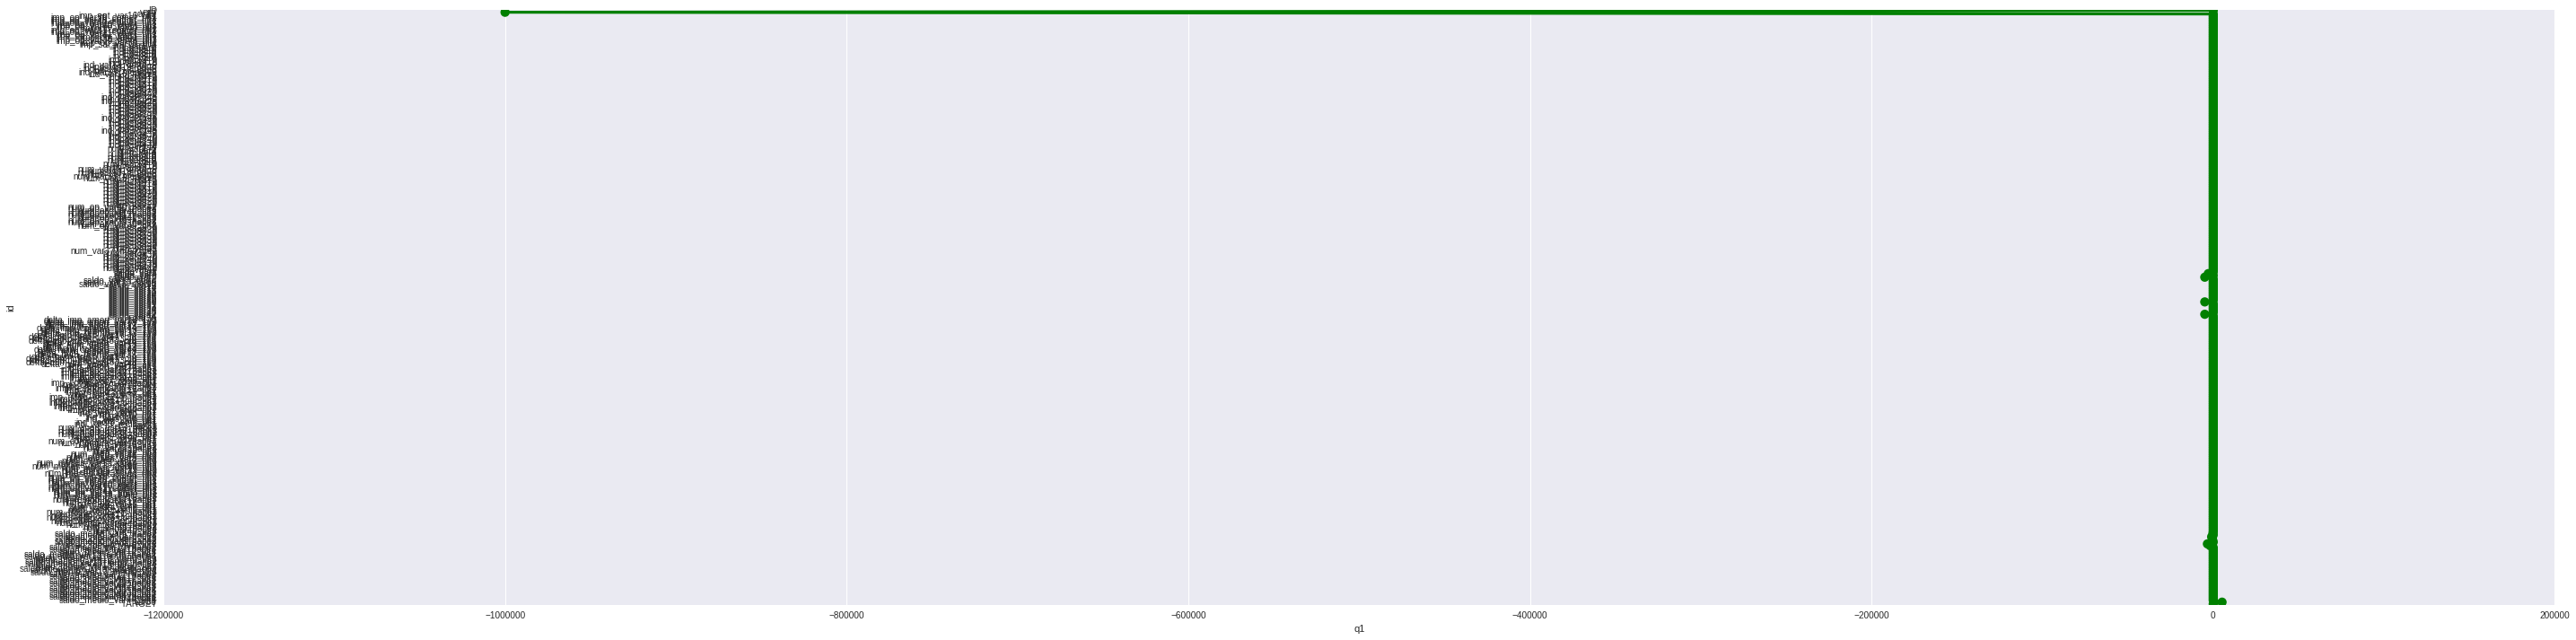

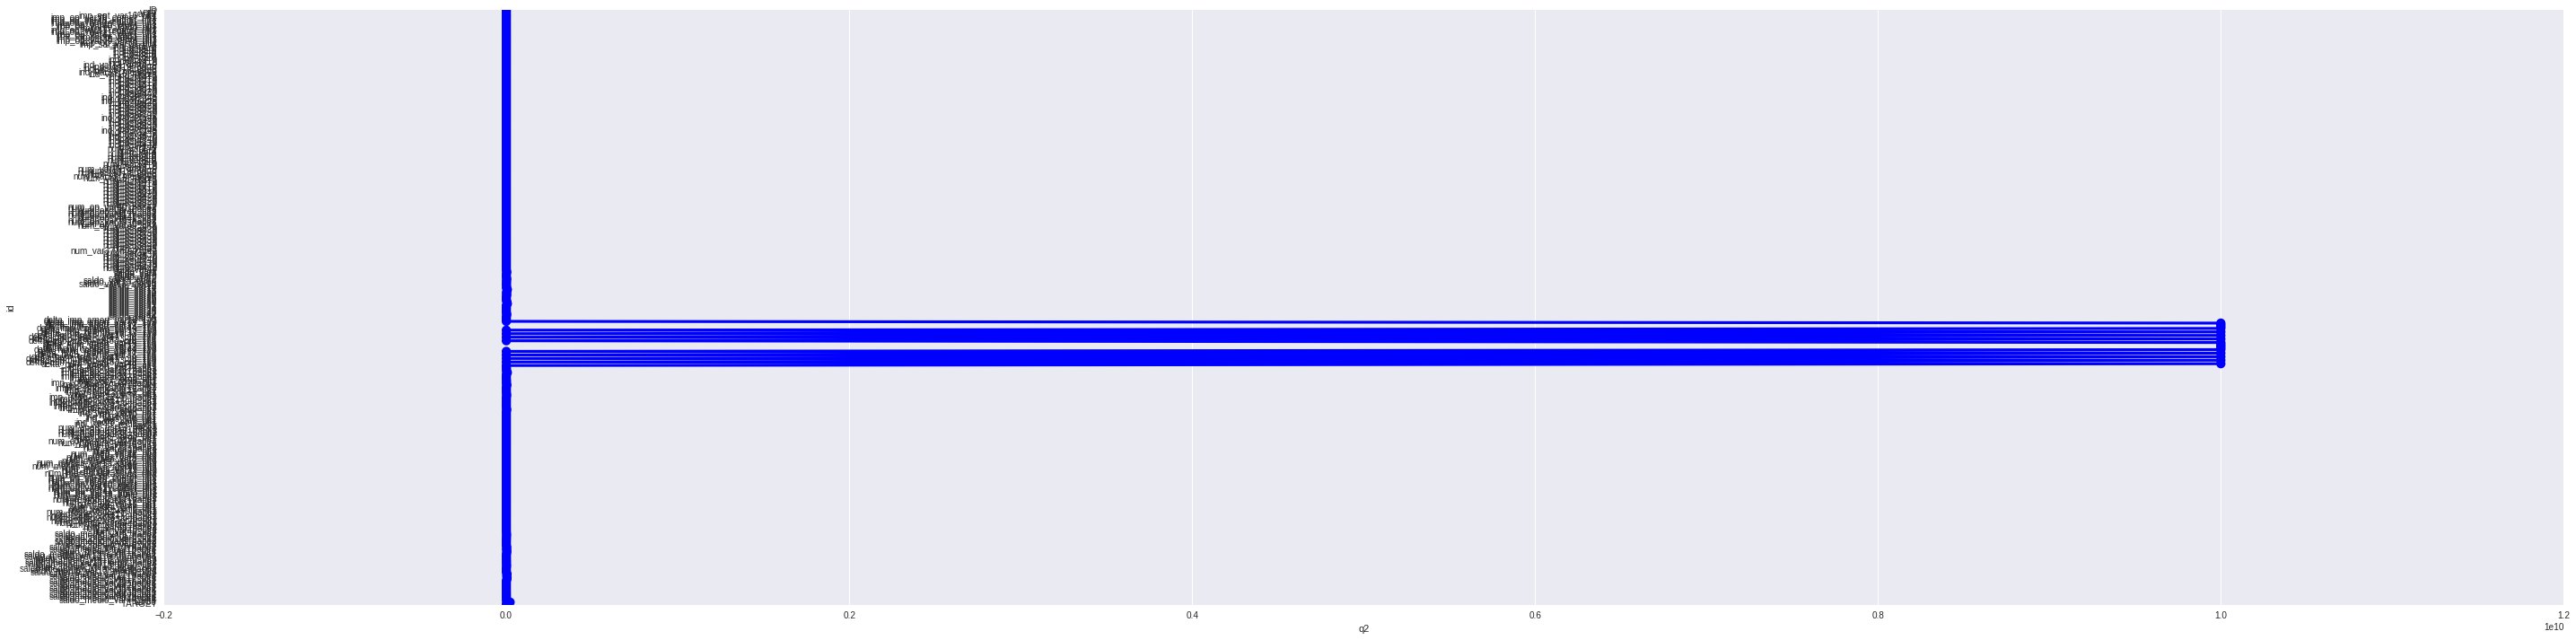

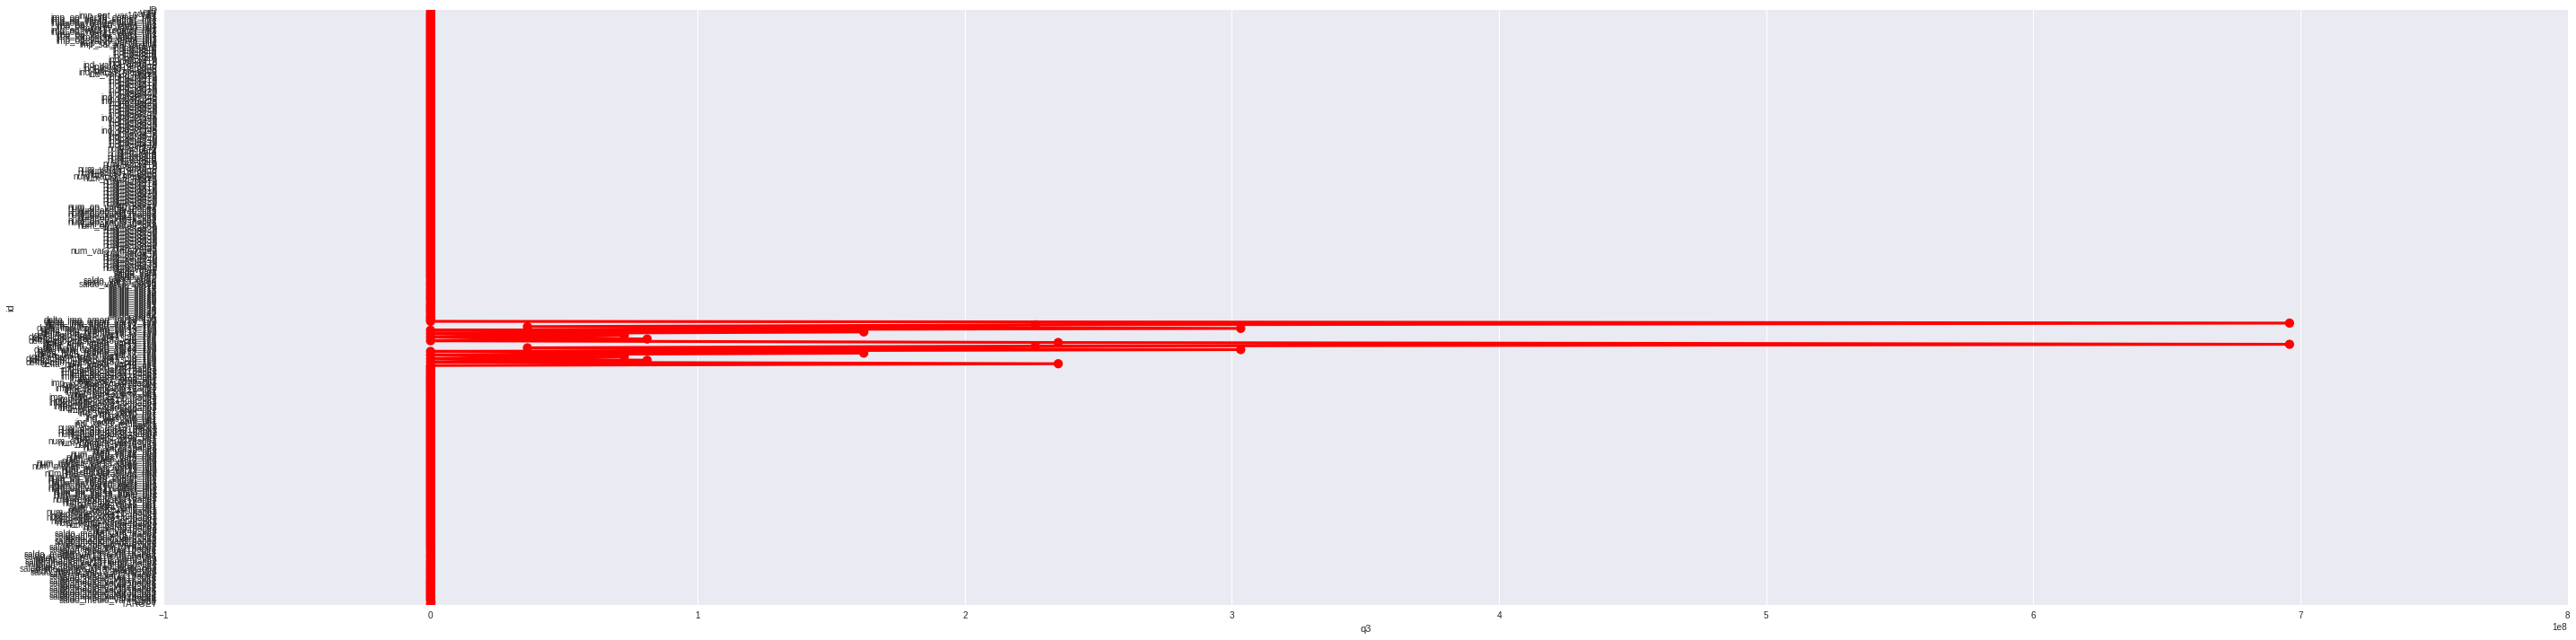

In [13]:
q1 = train_df.apply(np.min, axis=0)
q2 = train_df.apply(np.max, axis=0)
q3 = train_df.apply(np.std, axis=0)
q_df = pd.DataFrame({"q1": q1, "q2": q2, "q3": q3})
q_df["id"] = q_df.index
sns.factorplot(y="id", x="q1", data=q_df, size = 10, aspect = 4, color = "green")
sns.factorplot(y="id", x="q2", data=q_df, size = 10, aspect = 4, color = "blue")
sns.factorplot(y="id", x="q3", data=q_df, size = 10, aspect = 4, color = "red")

In [14]:
print("Min")
print(abs(q1).sort_values().tail(25))
print("\nMax")
print(abs(q2).sort_values().tail(25))
print("\nStd")
print(abs(q3).sort_values().tail(25))

Min
delta_num_trasp_var17_in_1y3         1.00
delta_num_reemb_var17_1y3            1.00
delta_num_aport_var33_1y3            1.00
delta_num_aport_var17_1y3            1.00
delta_num_aport_var13_1y3            1.00
delta_imp_aport_var33_1y3            1.00
delta_imp_trasp_var33_in_1y3         1.00
delta_imp_venta_var44_1y3            1.00
ID                                   1.00
delta_imp_reemb_var17_1y3            1.00
delta_imp_trasp_var17_in_1y3         1.00
var15                                5.00
saldo_medio_var5_hace3               8.04
saldo_medio_var5_hace2             128.37
saldo_medio_var8_hace2             287.67
saldo_medio_var5_ult3              476.07
saldo_medio_var5_ult1              922.38
saldo_medio_var8_ult3             1844.52
saldo_var5                        2895.72
saldo_medio_var8_ult1             3401.34
saldo_var8                        4942.26
saldo_var30                       4942.26
saldo_var42                       4942.26
var38                         

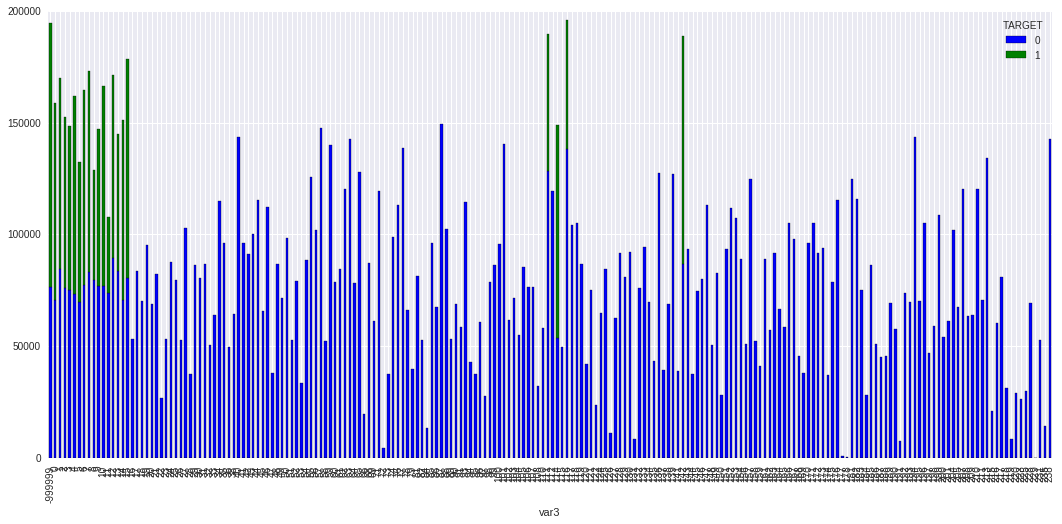

In [15]:
fig, axes = plt.subplots(ncols = 1, nrows = 1)
fig.set_size_inches(18, 8)
train_df.pivot_table("ID", "var3", "TARGET").plot(ax = axes, kind = "bar", stacked = True)

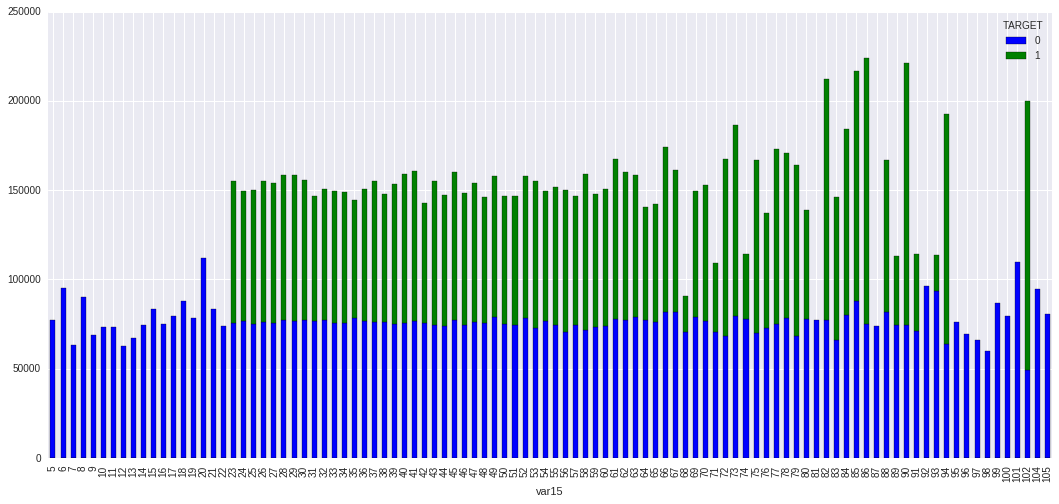

In [16]:
fig, axes = plt.subplots(ncols = 1, nrows = 1)
fig.set_size_inches(18, 8)
train_df.pivot_table("ID", "var15", "TARGET").plot(ax = axes, kind = "bar", stacked = True)

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7fce7cf75588>,
       <matplotlib.axes._subplots.AxesSubplot object at 0x7fce7cea59b0>], dtype=object)

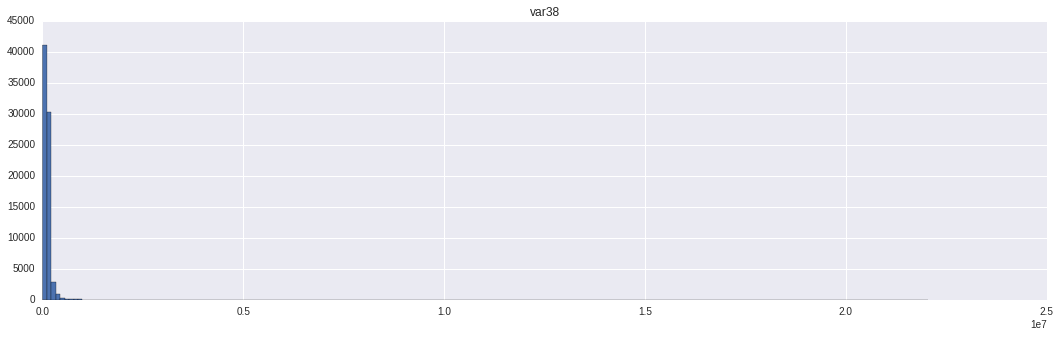

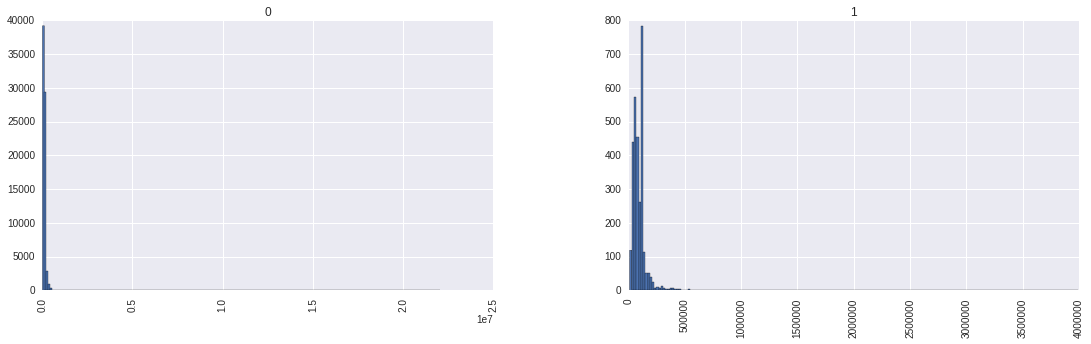

In [17]:
# fig, axes = plt.subplots(ncols = 1, nrows = 1)
# fig.set_size_inches(18, 8)
# train_df.pivot_table("ID", "var38", "TARGET").plot(ax = axes, kind = "bar", stacked = True)

col = "var38"
train_df.hist(col, bins = 200, figsize=(18, 5))
train_df.hist(col, "TARGET", bins = 200, figsize=(18, 5))

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7fce7c25bf28>,
       <matplotlib.axes._subplots.AxesSubplot object at 0x7fce7c3007b8>], dtype=object)

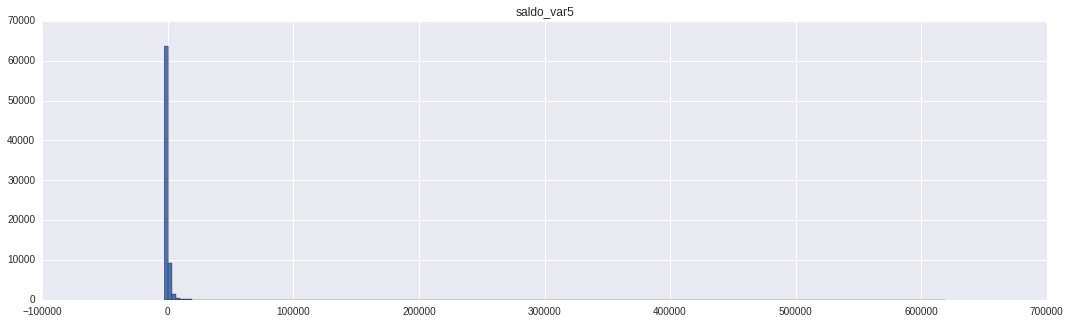

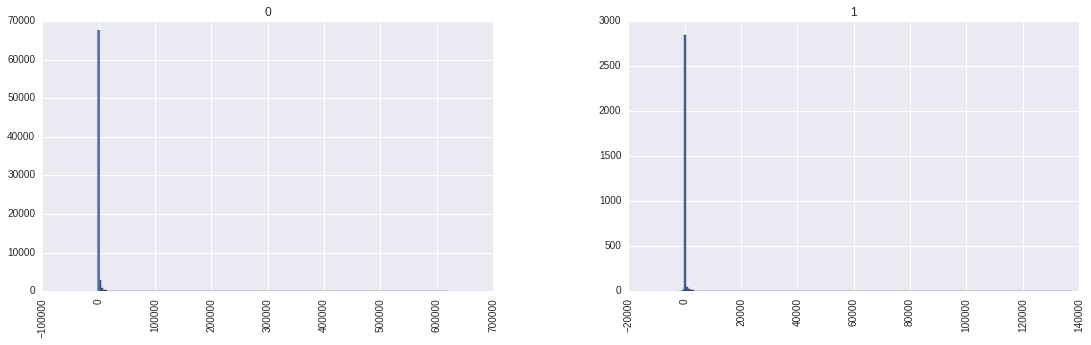

In [18]:
# fig, axes = plt.subplots(ncols = 1, nrows = 1)
# fig.set_size_inches(18, 8)
# train_df.pivot_table("ID", "saldo_var5", "TARGET").plot(ax = axes, kind = "bar", stacked = True)

col = "saldo_var5"
train_df.hist(col, bins = 200, figsize=(18, 5))
train_df.hist(col, "TARGET", bins = 200, figsize=(18, 5))

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7fce7a925630>,
       <matplotlib.axes._subplots.AxesSubplot object at 0x7fce7d0ffc18>], dtype=object)

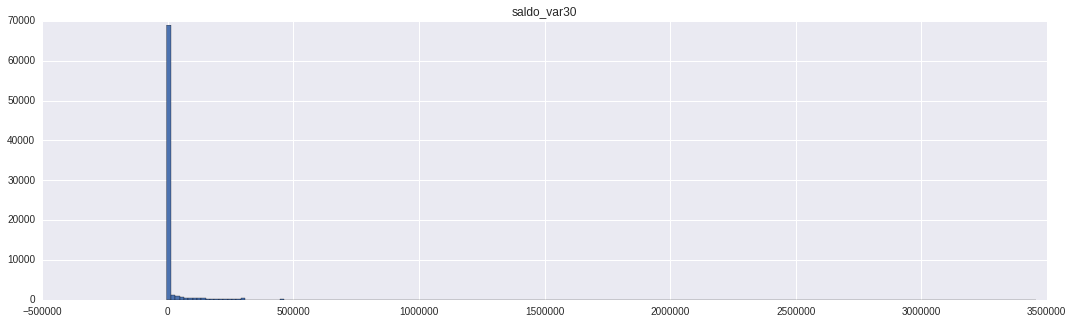

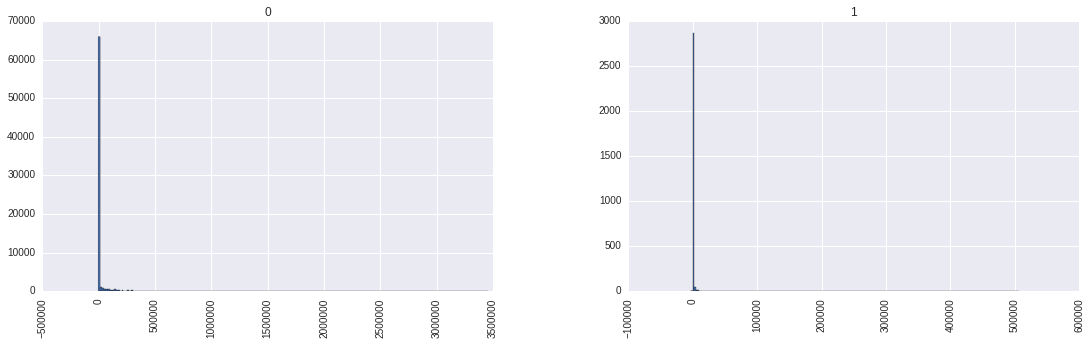

In [19]:
# fig, axes = plt.subplots(ncols = 1, nrows = 1)
# fig.set_size_inches(18, 8)
# train_df.pivot_table("ID", "saldo_var30", "TARGET").plot(ax = axes, kind = "bar", stacked = True)

col = "saldo_var30"
train_df.hist(col, bins = 200, figsize=(18, 5))
train_df.hist(col, "TARGET", bins = 200, figsize=(18, 5))

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7fce79342898>,
       <matplotlib.axes._subplots.AxesSubplot object at 0x7fce792b9208>], dtype=object)

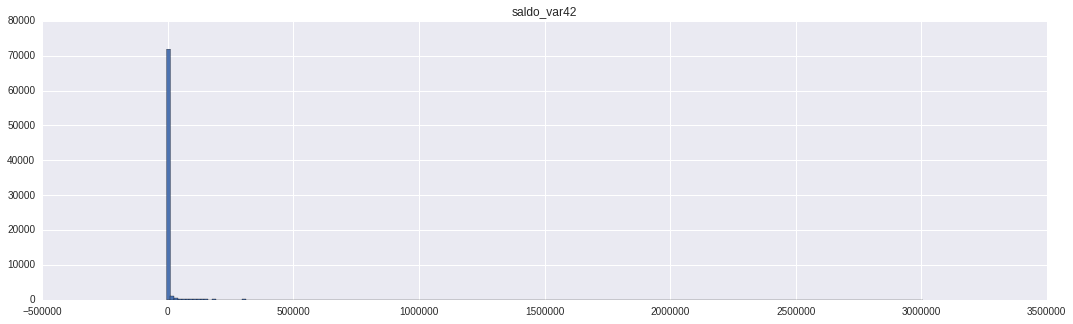

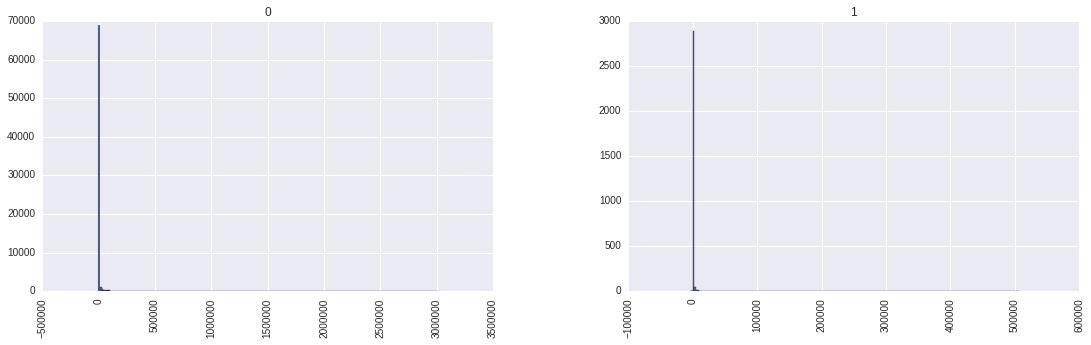

In [20]:
# fig, axes = plt.subplots(ncols = 1, nrows = 1)
# fig.set_size_inches(18, 8)
# train_df.pivot_table("ID", "saldo_var42", "TARGET").plot(ax = axes, kind = "bar", stacked = True)

col = "saldo_var42"
train_df.hist(col, bins = 200, figsize=(18, 5))
train_df.hist(col, "TARGET", bins = 200, figsize=(18, 5))

In [21]:
# col = "saldo_var42"
# train_df.hist(col, bins = 200, figsize=(18, 5))
# train_df.hist(col, "TARGET", bins = 200, figsize=(18, 5))

set(train_df["delta_imp_reemb_var33_1y3"])

{0, 1}

In [22]:
# New dummy features:
# var3 >= 16
# var3 == -999999, replace such var3 values with mean values
# var15 <= 22
# var38 <= 25
#
# Replace max with mean and add dummy variables:
# delta_imp_compra_var44_1y3
# delta_num_venta_var44_1y3
# delta_num_trasp_var33_in_1y3
# delta_num_trasp_var17_in_1y3
# delta_num_reemb_var17_1y3
# delta_num_compra_var44_1y3
# delta_num_aport_var33_1y3
# delta_num_aport_var17_1y3
# delta_imp_venta_var44_1y3
# delta_imp_trasp_var33_in_1y3
# delta_imp_aport_var13_1y3
# delta_imp_aport_var17_1y3
# delta_imp_aport_var33_1y3
# delta_imp_reemb_var17_1y3
# delta_num_aport_var13_1y3
# delta_imp_trasp_var17_in_1y3

feature = "var3"
train_df["dummy_" + feature] = 0
train_df.loc[train_df[feature] >= 16, "dummy_"+feature] = 1
test_X["dummy_" + feature] = 0
test_X.loc[test_X[feature] >= 16, "dummy_"+feature] = 1

mean_val = train_df.loc[train_df["var3"] != -999999, "var3"].mean()
train_df.loc[train_df["var3"] == -999999, "var3"] = mean_val
test_X.loc[test_X["var3"] == -999999, "var3"] = mean_val

feature = "var15"
train_df["dummy_" + feature] = 0
train_df.loc[train_df[feature] <= 22, "dummy_"+feature] = 1
test_X["dummy_" + feature] = 0
test_X.loc[test_X[feature] <= 22, "dummy_"+feature] = 1

feature = "var38"
train_df["dummy_" + feature] = 0
train_df.loc[train_df[feature] <= 25, "dummy_"+feature] = 1
test_X["dummy_" + feature] = 0
test_X.loc[test_X[feature] <= 25, "dummy_"+feature] = 1

delta_features = ['delta_imp_compra_var44_1y3', 'delta_num_venta_var44_1y3', 'delta_num_trasp_var33_in_1y3', 
                  'delta_num_trasp_var17_in_1y3', 'delta_num_reemb_var17_1y3', 'delta_num_compra_var44_1y3', 
                  'delta_num_aport_var33_1y3', 'delta_num_aport_var17_1y3', 'delta_imp_venta_var44_1y3', 
                  'delta_imp_trasp_var33_in_1y3', 'delta_imp_aport_var13_1y3', 'delta_imp_aport_var17_1y3', 
                  'delta_imp_aport_var33_1y3', 'delta_imp_reemb_var17_1y3', 'delta_num_aport_var13_1y3', 
                  'delta_imp_trasp_var17_in_1y3']
for de_fe in delta_features:
    max_val = train_df[de_fe].max()
    mean_val = train_df.loc[train_df[de_fe] != max_val, de_fe].mean()
    train_df.loc[train_df[de_fe] == max_val, de_fe] = mean_val
    test_X.loc[test_X[de_fe] == max_val, de_fe] = mean_val

/home/vadim/anaconda3/lib/python3.5/site-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [337] are constant.
  UserWarning)


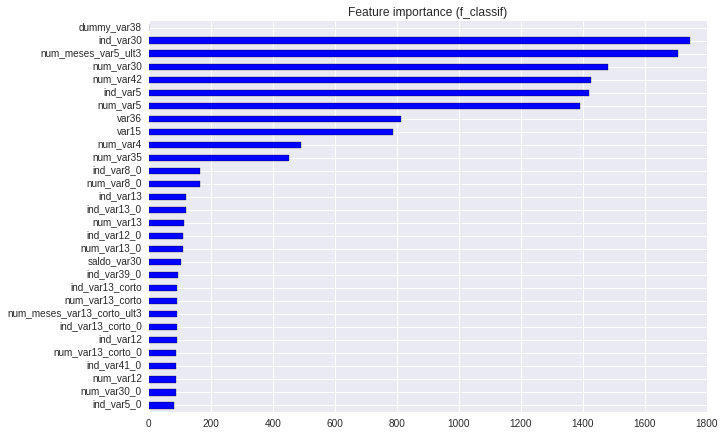

In [25]:
#
# Feature Selection
#
llama = imp.reload(llama)

train_X, train_y = llama.split_train_set(train_df.drop("ID", 1), "TARGET")
top_features = 30

# SelectKBest with ANOVA
feat_imp_anova = llama.anova_best_features(train_X, train_y, top_features)

In [48]:
# RFECV
llama = imp.reload(llama)

train_X, train_y = llama.split_train_set(train_df.drop("ID", 1), "TARGET")
indices = llama.downsample(train_y, 20000)
train_X = train_X.loc[indices, :]
train_y = train_y[indices]

feat_imp_rfe_lin, feat_imp_rfe_log = llama.rfe_best_features(train_X, train_y)

/home/vadim/anaconda3/lib/python3.5/site-packages/pandas/core/index.py:6154: RuntimeWarning: unorderable types: str() < int(), sort order is undefined for incomparable objects
  result = result.union(other)


In [27]:
# L1-based
# Randomized lasso
# feat_imp

In [ ]:
# # feat_imp.hist(by=1, sharex=True, sharey=True)
feat_imp_na = feat_imp_rfe
feat_imp_rfe = feat_imp_rfe.dropna()
plt.figure(figsize=(14, 7))
plt.hist(feat_imp_rfe.loc[feat_imp[1] == "Linear", 0], bins = 50, alpha=0.5, label='linear')
plt.hist(feat_imp_rfe.loc[feat_imp[1] == "Logistic", 0], bins = 50, alpha=0.5, label='logistic')
plt.legend(loc='upper right')
plt.show()

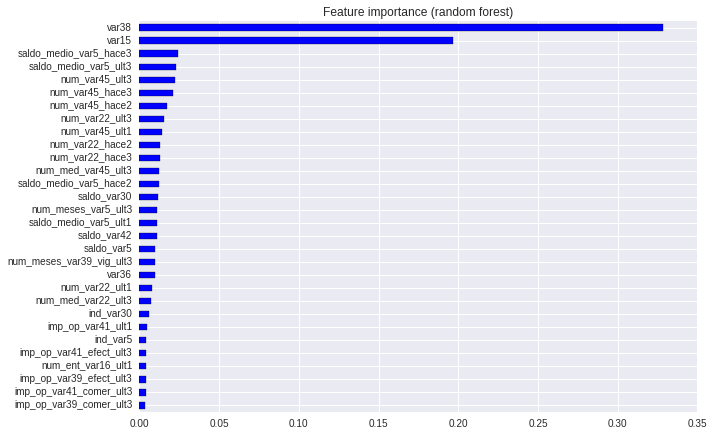

In [31]:
# Trees
llama = imp.reload(llama)
feat_imp_tree = llama.tree_best_features(train_X, train_y, top_features)

In [156]:
llama = imp.reload(llama)

train_X, train_y = llama.split_train_set(train_df.drop("ID", 1), "TARGET")
train_X = resample(train_X, n_samples = 30000)

cv_fold = StratifiedKFold(train_y, n_folds = 5, shuffle = True)
cv_col = [cv for cv in cv_fold][0]
val_col = np.ndarray(shape = 1 + (max(cv_col[0].max(), cv_col[1].max())))
val_col[cv_col[0]] = 0
val_col[cv_col[1]] = 1
print(sum(train_y))
print(sum(train_df["TARGET"]))
print(sum(train_y[val_col] == 0))
print(sum(train_y[val_col] == 1))

3008
3008
76020
0


In [151]:
resample(train_y == 1, n_samples = 100000).shape

ValueError: Cannot sample 100000 out of arrays with dim 76020

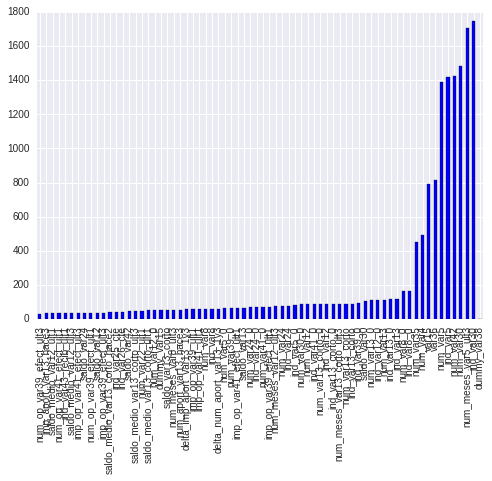

In [46]:
feat_imp_anova.tail(70).plot(kind = "bar")

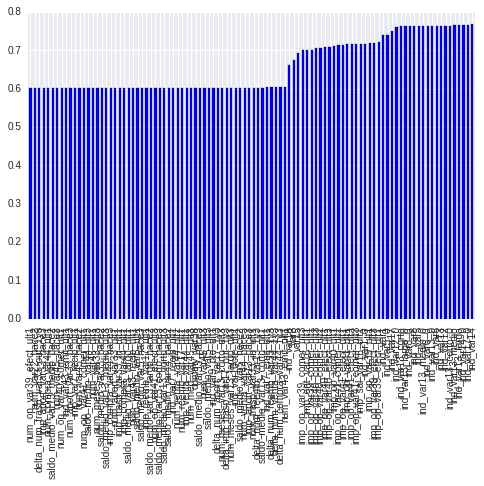

In [64]:
feat_imp_rfe_log.sort_values().tail(100).plot(kind = "bar")

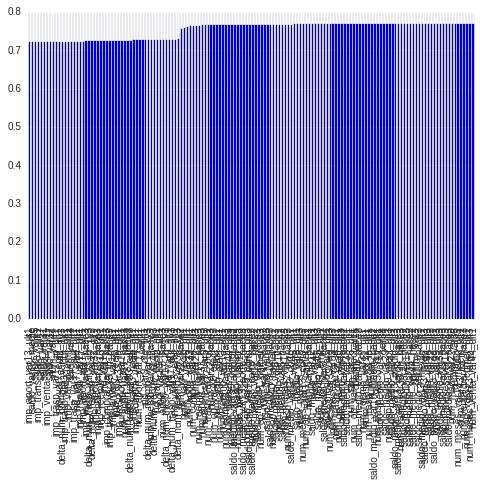

In [63]:
feat_imp_rfe_lin.sort_values().tail(150).plot(kind = "bar")

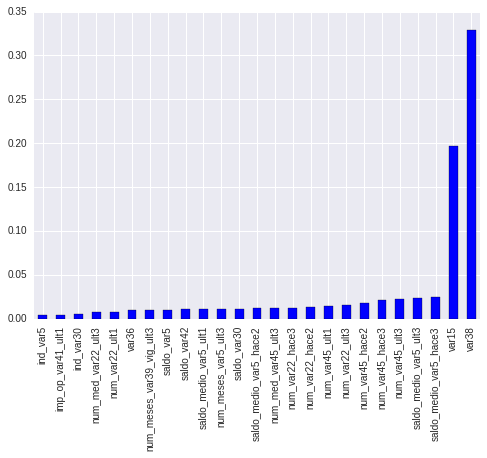

In [45]:
feat_imp_tree.tail(25).plot(kind = "bar")

In [50]:
train_X2 = llama.take_features(feat_imp_tree.tail(25), train_X)[0]
train_X2.describe()

,ind_var5,imp_op_var41_ult1,ind_var30,num_med_var22_ult3,num_var22_ult1,var36,num_meses_var39_vig_ult3,saldo_var5,saldo_var42,saldo_medio_var5_ult1,...,num_var22_hace2,num_var45_ult1,num_var22_ult3,num_var45_hace2,num_var45_hace3,num_var45_ult3,saldo_medio_var5_ult3,saldo_medio_var5_hace3,var15,var38
count,20000.000000,20000.000000,20000.00000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,...,20000.000000,20000.000000,20000.000000,20000.00000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000
mean,0.663700,131.724996,0.73435,0.639150,0.568500,40.416150,1.595300,1098.402794,7461.252647,1176.692730,...,1.292850,4.351950,3.051900,5.36760,3.893850,13.613400,1103.965881,857.179884,33.285450,117221.135717
std,0.472455,596.850552,0.44169,1.813147,2.085408,47.358038,0.720725,11561.438253,51270.061431,11316.270494,...,3.369088,14.169556,6.159805,14.32006,10.709921,33.199415,8719.106727,7459.466341,12.864258,160373.749279
min,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,-2895.720000,-4942.260000,-922.380000,...,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,-476.070000,-6.090000,5.000000,5163.750000
25%,0.000000,0.000000,0.00000,0.000000,0.000000,2.000000,1.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,23.000000,68011.357500
50%,1.000000,0.000000,1.00000,0.000000,0.000000,3.000000,2.000000,3.000000,3.000000,3.000000,...,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,2.730000,0.990000,28.000000,106334.445000
75%,1.000000,0.000000,1.00000,0.000000,0.000000,99.000000,2.000000,90.000000,120.000000,90.000000,...,0.000000,3.000000,3.000000,3.00000,3.000000,12.000000,84.007500,12.450000,40.000000,119028.570000
max,1.000000,18576.000000,1.00000,48.000000,42.000000,99.000000,3.000000,619329.150000,2835348.300000,601428.600000,...,60.000000,510.000000,144.000000,288.00000,339.000000,801.000000,481675.500000,342268.560000,102.000000,11857856.460000


In [73]:
llama = imp.reload(llama)
train_X2 = llama.take_features(feat_imp_tree.tail(25), train_X)[0]
tree25 = llama.train_xgb(train_X2, train_y, cv_fold)

1. Number of estimators...Done.
2. Depth and chind weights...Done.
3. Number of estimators...Done.
4. Gamma...Done.
5. Sample and colsample...Done.
6. Regularization...Done.
7. Number of estimators and the learning rate...Done.
XGBClassifier(base_score=0.5, colsample_bylevel=1, colsample_bytree=1.0,
       gamma=0.1, learning_rate=0.05, max_delta_step=0, max_depth=9,
       min_child_weight=9, missing=None, n_estimators=100, nthread=8,
       objective='binary:logistic', reg_alpha=1e-05, reg_lambda=1,
       scale_pos_weight=1, seed=0, silent=True, subsample=1.0)
CV scores: [ 0.82127699  0.83245471  0.83461089  0.80686853  0.83954238]
=>	0.826950700863 (+-0.0116876663659)


In [ ]:
llama = imp.reload(llama)
train_X2 = llama.take_features(feat_imp_anova.tail(70), train_X)[0]
xanova70 = llama.train_xgb(train_X2, train_y, cv_fold)

1. Number of estimators... Done.

In [ ]:
llama = imp.reload(llama)
train_X2 = llama.take_features(feat_imp_rfe_lin.sort_values().tail(110), train_X)[0]
xlin110 = llama.train_xgb(train_X2, train_y, cv_fold)

In [ ]:
llama = imp.reload(llama)
train_X2 = llama.take_features(feat_imp_rfe_log.sort_values().tail(45), train_X)[0]
xlog45 = llama.train_xgb(train_X2, train_y, cv_fold)

In [ ]:
train_X2 = llama.take_features(feat_imp_tree.tail(25), train_X)[0]
llama.print_cv_scores(tree25, train_X2, train_y, cv_fold)

train_X2 = llama.take_features(feat_imp_anova.tail(70), train_X)[0]
llama.print_cv_scores(xanova70, train_X2, train_y, cv_fold)

train_X2 = llama.take_features(feat_imp_rfe_lin.sort_values().tail(110), train_X)[0]
llama.print_cv_scores(xlin110, train_X2, train_y, cv_fold)

train_X2 = llama.take_features(feat_imp_rfe_log.sort_values().tail(45), train_X)[0]
llama.print_cv_scores(xlog45, train_X2, train_y, cv_fold)

In [78]:
train_X2 = llama.take_features(feat_imp_tree.tail(25), train_X)[0]
llama.per_clf_report(tree25, train_X2, train_y, val_col, cv_fold)

train_X2 = llama.take_features(feat_imp_anova.tail(70), train_X)[0]
llama.per_clf_report(xanova70, train_X2, train_y, val_col, cv_fold)

train_X2 = llama.take_features(feat_imp_rfe_lin.sort_values().tail(110), train_X)[0]
llama.per_clf_report(xlin110, train_X2, train_y, val_col, cv_fold)

train_X2 = llama.take_features(feat_imp_rfe_log.sort_values().tail(45), train_X)[0]
llama.per_clf_report(xlog45, train_X2, train_y, val_col, cv_fold)

XGBClassifier(base_score=0.5, colsample_bylevel=1, colsample_bytree=1.0,
       gamma=0.1, learning_rate=0.05, max_delta_step=0, max_depth=9,
       min_child_weight=9, missing=None, n_estimators=100, nthread=8,
       objective='binary:logistic', reg_alpha=1e-05, reg_lambda=1,
       scale_pos_weight=1, seed=0, silent=True, subsample=1.0)
CV scores: [ 0.82127699  0.83245471  0.83461089  0.80686853  0.83954238]
=>	0.826950700863 (+-0.0116876663659)

Metrics:
             precision    recall  f1-score   support

          0       0.96      1.00      0.98      7684
          1       1.00      0.01      0.02       317

avg / total       0.96      0.96      0.94      8001

Confusion matrix:
Cls	0	1
0	7684	0
1	314	3
XGBClassifier(base_score=0.5, colsample_bylevel=1, colsample_bytree=1.0,
       gamma=0.8, learning_rate=0.05, max_delta_step=0, max_depth=6,
       min_child_weight=9, missing=None, n_estimators=100, nthread=8,
       objective='binary:logistic', reg_alpha=1e-05, reg_lambda=1,


/home/vadim/anaconda3/lib/python3.5/site-packages/sklearn/metrics/classification.py:1074: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [29]:
llama = imp.reload(llama)

llama.model_eval_report([("tree25", tree25), ("xanova70", xanova70), ('xlin110', xlin110),
                         ("xlog45", xlog45)], 
                        train_X, train_y, val_col)
# cross_val_score(clf, train_X, train_y, "roc_auc", cv_fold, n_jobs=2)

In [105]:
# choose n estimators
# choose max depth, min child weight
# again choose n estimators
# choose gamma
# tune subsample and colsample by tree
# reduce learning rate + add more trees

# for n_est in [50, 100, 150, 200, 250, 300]:
#     clf     = xgb.XGBClassifier(nthread = 8,
#                                 max_depth = 5, 
#                                 n_estimators = n_est,
#                                 learning_rate = .05,
#                                 min_child_weight = 6, 
#     #                             max_delta_step = 0,   # 1 for imbalanced classes
#     #                             gamma = 0, 
#                                 subsample = .9,
#                                 colsample_bytree = .7,
#                                 reg_alpha = 0,
#                                 reg_lambda = 0, 
#                                 scale_pos_weight = 1)
#     llama.print_cv_scores(clf, train_X, train_y, cv_fold)

clf     = xgb.XGBClassifier(nthread = 8,
                            max_depth = 5, 
                            n_estimators = 150,
                            learning_rate = .05,
                            min_child_weight = 6, 
                            max_delta_step = 0,   # 1 for imbalanced classes
                            gamma = 0.8, 
                            subsample = .9,
                            colsample_bytree = .9,
                            reg_alpha = 0,
                            reg_lambda = 0, 
                            scale_pos_weight = 1)
# parameters = {
#      "n_estimators": [100, 300, 600, 800, 1000, 1300]
# }
# parameters = {"max_depth": [2, 3, 4, 5],
#              "min_child_weight": [6, 7, 8]
#              }
# parameters = {
#     'gamma':  list(range(0, 1,1, .1))
# }
parameters = {
    'reg_alpha':  [1e-6, 1e-5, 1e-4, 1e-3],
    'reg_lambda': [1e-6, 1e-5, 1e-4, 1e-3]
}

clf_best = GridSearchCV(clf, parameters, cv=cv_fold, n_jobs = 1)
clf_best.fit(train_X, train_y)
clf = clf_best.best_estimator_
llama.print_cv_scores(clf, train_X, train_y, cv_fold)

XGBClassifier(base_score=0.5, colsample_bylevel=1, colsample_bytree=0.9,
       gamma=0.8, learning_rate=0.05, max_delta_step=0, max_depth=5,
       min_child_weight=6, missing=None, n_estimators=150, nthread=8,
       objective='binary:logistic', reg_alpha=1e-06, reg_lambda=1e-06,
       scale_pos_weight=1, seed=0, silent=True, subsample=0.9)
CV scores: [ 0.84194307  0.8055363   0.83114898  0.83344308  0.85090783]
=>	0.832595849189 (+-0.0152166327299)


In [91]:
clf = xgb.XGBClassifier(base_score=0.5, colsample_bylevel=1, colsample_bytree=0.9,
       gamma=0.8, learning_rate=0.02, max_delta_step=0, max_depth=5,
       min_child_weight=6, missing=None, n_estimators=1000, nthread=8,
       objective='binary:logistic', reg_alpha=1e-06, reg_lambda=1e-06,
       scale_pos_weight=12, seed=0, silent=True, subsample=0.9)

clf.fit(train_X, train_y)

llama.per_clf_report(clf, train_X, train_y, val_col, cv_fold)

XGBClassifier(base_score=0.5, colsample_bylevel=1, colsample_bytree=0.9,
       gamma=0.8, learning_rate=0.02, max_delta_step=0, max_depth=5,
       min_child_weight=6, missing=None, n_estimators=1000, nthread=8,
       objective='binary:logistic', reg_alpha=1e-06, reg_lambda=1e-06,
       scale_pos_weight=12, seed=0, silent=True, subsample=0.9)
CV scores: [ 0.81487999  0.81894144  0.82686221  0.79990943  0.83173067]
=>	0.818464746776 (+-0.0109898100291)

Metrics:
             precision    recall  f1-score   support

          0       0.99      0.89      0.94      7684
          1       0.23      0.80      0.36       317

avg / total       0.96      0.89      0.92      8001

Confusion matrix:
Cls	0	1
0	6842	842
1	62	255


In [1]:
# Get features from each feature-extraction procedure and train different XGBs / forests on them
# XGB - all features, ANOVA, RFE, tree, ridge; 
# average them with regression / mean / xgb  

In [93]:
train_X, train_y = llama.split_train_set(train_df.drop("ID", 1), "TARGET")
clf.set_params(nthread = 8)
clf.fit(train_X, train_y)
pred = clf.predict_proba(test_X.drop("ID", 1))
pred_df = pd.DataFrame({"ID": test_X.ID, "TARGET": pred[:,1]})
pred_df.to_csv("submission.csv", index = False)

In [34]:
"""
ExtraTreesClassifier(n_estimators=2000, n_jobs = 4)
array([ 0.78135125,  0.78413756,  0.77074728,  0.76621595,  0.77887001])

xgb_clf = xgb.XGBClassifier(max_depth=2, n_estimators=1000, learning_rate=0.05, nthread=7)
array([ 0.84455681,  0.84528062,  0.82965851,  0.83049845,  0.83485219])

XGBClassifier(base_score=0.5, colsample_bylevel=1, colsample_bytree=0.7, gamma=0, learning_rate=0.05, 
max_delta_step=0, max_depth=3, min_child_weight=7, missing=None, n_estimators=150, nthread=8, 
objective='binary:logistic', reg_alpha=0, reg_lambda=0, scale_pos_weight=1, seed=0, silent=True, subsample=0.9) 
CV scores: [ 0.8306504 0.84211303 0.8385074 0.84425729 0.832733 ] => 0.837652225791 (+-0.00524368924185)
0.836118

"""

'\nExtraTreesClassifier(n_estimators=2000, n_jobs = 4)\narray([ 0.78135125,  0.78413756,  0.77074728,  0.76621595,  0.77887001])\n\nxgb_clf = xgb.XGBClassifier(max_depth=2, n_estimators=1000, learning_rate=0.05, nthread=7)\narray([ 0.84455681,  0.84528062,  0.82965851,  0.83049845,  0.83485219])\n\n\n'